In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import statsmodels as sm
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

### Parameters

In [2]:
filename = './data/ML_IGE_ENTRANTS_MODELE1.csv'

# myfilters = {'SITE':'VELIZY','FLUX_ACTIVITE':'Flux Prestation','SERVICE_ACTIVITE':'PRESTATION','MEDIA':'Courrier'}
myfilters = {'SITE':'VELIZY','FLUX_ACTIVITE':'FLUX PRESTATION','SERVICE_ACTIVITE':'PRESTATION'}

testsize = 0.05

scale='B' # 'B','W','SM'

### Import csv

In [3]:
df = pd.read_csv(filename,sep=';',engine='python') #,index_col='DATEDATA',parse_dates=True)

In [4]:
df

,SITE,DATEDATA,CLIENT,FLUX_ACTIVITE,SECTEUR_ACTIVITE,SERVICE_ACTIVITE,MEDIA,TYPEDOSSIER,REGROUPEMENTTDB,TOTAL
0,COURBEVOIE,2019-09-18,BCAC,Flux Décès,Prévoyance,PREVOYANCE,Email,Ouverture dossier Décès,Dossiers Prévoyance,4
1,COURBEVOIE,2019-12-02,BCAC,Flux Prestation,Prestations,PRESTATION,LR/AR,Prestations,Dossiers Prestations,4
2,MARSEILLE,2020-01-06,ISTYACO GESTION,Flux Noemie,EDI,CONTRAT - COTISATION,Appel,Echanges Noémie,Dossiers EDI,2
3,MARSEILLE,2019-08-29,ISTYACO GESTION,Flux Devis,Prestations,PRESTATION,Courrier,Devis dentaire,Dossiers Devis,4
4,VELIZY,2018-08-07,KLESIA PREVOYANCE,Flux Cotisation,Contrats- Cotisations,CONTRAT - COTISATION,Appel,Cotisations individuelles,Dossiers Cotisations,1
...,...,...,...,...,...,...,...,...,...,...
378790,VELIZY,2019-01-21,K2 - MUTUELLE FAMILIALE DES CHEMINOTS DE FRANCE,Flux E/S,Contrats- Cotisations,CONTRAT - COTISATION,Courrier,Radiation - Portabilité,Dossiers Administratifs,1
378791,MARSEILLE,2019-10-29,ISTYACO GESTION,Flux Administratif,Contrats- Cotisations,CONTRAT - COTISATION,Email,Autre,Dossiers Informations,1
378792,VELIZY,2020-05-22,KLESIA - MUTUELLE GEODIS,Flux Administratif,Contrats- Cotisations,CONTRAT - COTISATION,Email,Attestation SS,Dossiers EDI,1
378793,MARSEILLE,2018-08-22,MCDEF DELEGATION,Flux PEC,TP,PRESTATION,Courrier,PEC Hospitalière,Dossiers Pec,1


### Preprocess columns

In [5]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df = df.apply(lambda x: x.str.upper() if x.dtype == "object" else x)

### Encode exog

In [6]:
def encod_exogs(df, cols):
    dfenc=[]
    concatlist = [df]
    for i,col in enumerate(cols):
        exog_var = df[col].fillna('Unknown').to_numpy().reshape(-1,1)
        encod_fit = LabelBinarizer().fit(exog_var)
        encoded = encod_fit.transform(exog_var)
        dfenc.append(pd.DataFrame(encoded,columns=encod_fit.classes_))
        concatlist.append(dfenc[i])

    dfnew = pd.concat(concatlist,axis=1)
    return dfnew

dfnew = encod_exogs(df,['MEDIA'])

### Filter

In [7]:
def filter_df(df, mydict):
    df_filter = df.copy()
    for key,value in mydict.items():
        df_filter = df_filter[df_filter[key]==value]
    return df_filter
    
df_filter = filter_df(dfnew, myfilters)

In [8]:
df_filter.shape

(37905, 23)

### Create Aggregated Df with DateTime Index

In [9]:
df2 = df_filter.groupby('DATEDATA').sum()
df2 = df2.asfreq(freq='B')
df2['TOTAL'].fillna(0,inplace=True)

In [10]:
df2['ANO BATCH']=df2['ANO BATCH']+df2['ANOS BATCHS']
df2['EMAIL']=df2['EMAIL']+df2['COURRIEL']
df2 = df2[df2.index>='2018-08-01'].drop(columns=['ANOS BATCHS','COURRIEL'])

In [11]:
df2.describe()

,TOTAL,ANO BATCH,APPEL,AUDIO,COURRIER,CPAM,DSN,EMAIL,EXTRANET,FAX,LR/AR,Unknown
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.0
mean,1057.450505,0.022222,6.278788,0.387879,31.800000,0.008081,0.080808,23.347475,1.254545,0.062626,2.567677,0.0
std,378.655689,0.160689,2.880736,1.094269,8.653145,0.089620,0.367637,6.019576,2.966728,0.258689,2.423520,0.0
min,54.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,871.500000,0.000000,4.500000,0.000000,28.500000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.0
50%,1093.000000,0.000000,6.000000,0.000000,34.000000,0.000000,0.000000,24.000000,0.000000,0.000000,2.000000,0.0
75%,1272.000000,0.000000,8.000000,0.000000,38.000000,0.000000,0.000000,27.000000,0.000000,0.000000,4.000000,0.0
max,3253.000000,2.000000,15.000000,7.000000,49.000000,1.000000,3.000000,36.000000,15.000000,2.000000,13.000000,0.0


In [12]:
df2=df2.resample(scale).sum()

### Split in train test to compare with predictions

In [13]:
train,test = train_test_split(df2, test_size=testsize)

In [14]:
train_endog = train['TOTAL']
train_exog = train.drop(columns='TOTAL')

test_endog = test['TOTAL']
test_exog = test.drop(columns='TOTAL')

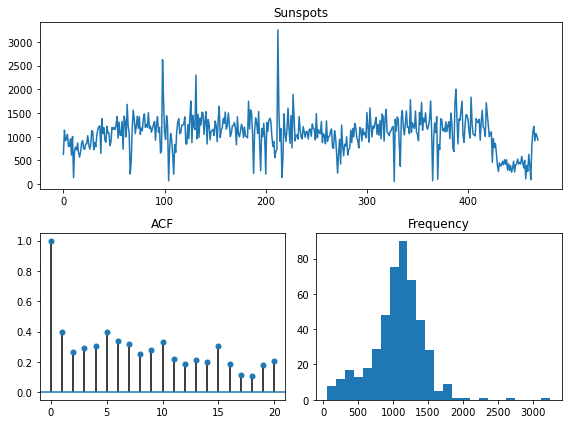

In [15]:
pm.tsdisplay(train_endog, lag_max=20, title="Sunspots", show=True)

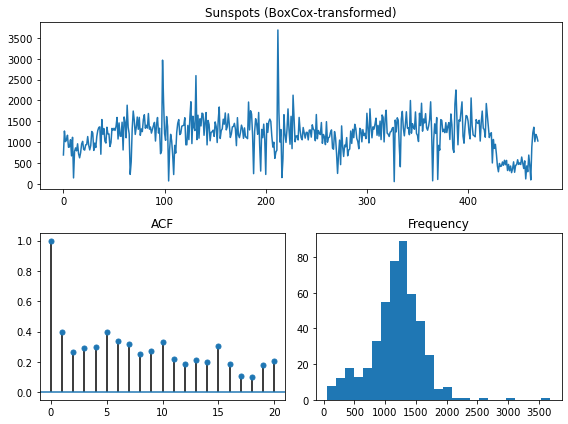

lambda None


In [16]:
from pmdarima import preprocessing

y_bc, l = preprocessing.BoxCoxEndogTransformer().fit_transform(train_endog)
pm.tsdisplay(y_bc, lag_max=20, title="Sunspots (BoxCox-transformed)", show=True)
print("lambda %s" % l)

### Model auto.arima

In [17]:
modl = pm.auto_arima(train_endog,exogenous=train_exog, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10,
                      seasonal=True, m=5)

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,0,1,5) [intercept=True]; AIC=6527.759, BIC=6606.661, Time=0.908 seconds
Fit ARIMA(0,0,0)x(0,0,0,5) [intercept=True]; AIC=6579.944, BIC=6633.929, Time=0.743 seconds
Fit ARIMA(1,0,0)x(1,0,0,5) [intercept=True]; AIC=6546.142, BIC=6608.433, Time=0.872 seconds
Fit ARIMA(0,0,1)x(0,0,1,5) [intercept=True]; AIC=6551.827, BIC=6614.118, Time=0.839 seconds
Fit ARIMA(0,0,0)x(0,0,0,5) [intercept=False]; AIC=6578.652, BIC=6628.485, Time=0.773 seconds
Fit ARIMA(2,0,2)x(0,0,1,5) [intercept=True]; AIC=6538.361, BIC=6613.110, Time=1.275 seconds
Fit ARIMA(2,0,2)x(1,0,0,5) [intercept=True]; AIC=6535.206, BIC=6609.955, Time=1.106 seconds
Fit ARIMA(2,0,2)x(2,0,1,5) [intercept=True]; AIC=6528.342, BIC=6611.396, Time=1.192 seconds
Fit ARIMA(2,0,2)x(1,0,2,5) [intercept=True]; AIC=6528.281, BIC=6611.335, Time=1.355 seconds
Fit ARIMA(2,0,2)x(0,0,0,5) [intercept=True]; AIC=6553.245, BIC=6623.842, Time=0.653 seconds
Fit ARIMA(2,0,2)x(0,0,2,5) [intercep

In [18]:
print(modl.order)
print(modl.seasonal_order)

(1, 0, 0)
(1, 0, 1, 5)


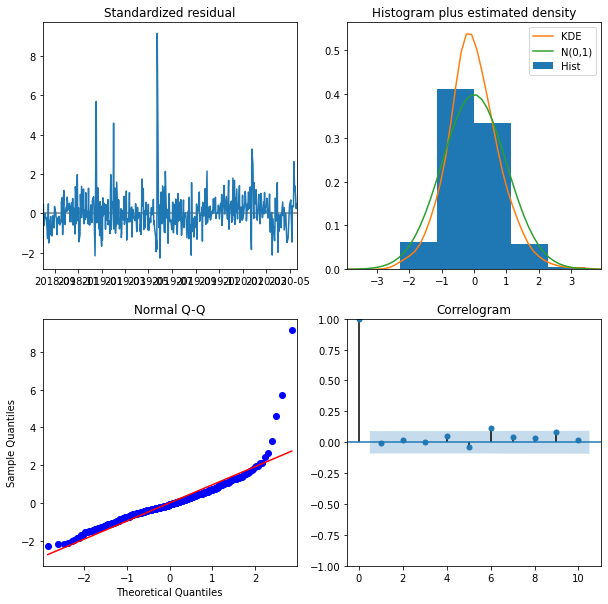

In [19]:
plt.rcParams['figure.figsize'] = [10, 10]
modl.plot_diagnostics();

In [20]:
preds, conf_int = modl.predict(n_periods=test.shape[0],exogenous=test_exog, return_conf_int=True)

### Model HoltWinters

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [22]:
modl2 = ExponentialSmoothing(train_endog, trend='add', damped=False, seasonal='add', seasonal_periods=5).fit()

In [23]:
hwpreds = modl2.predict(start=test_endog.index[0], end=test_endog.index[-1])

### Plot Result

In [24]:
graph = pd.DataFrame(test_endog.copy())
graph = graph.rename(columns={'TOTAL':'TEST'})
graph['preds'] = preds
# graph['hwpreds'] = hwpreds
graph['lb'] = conf_int[:,0]
graph['ub'] = conf_int[:,1]
graph = graph.append(pd.DataFrame(train_endog))

In [27]:
graphz = graph[graph.index>'2020-03-01']

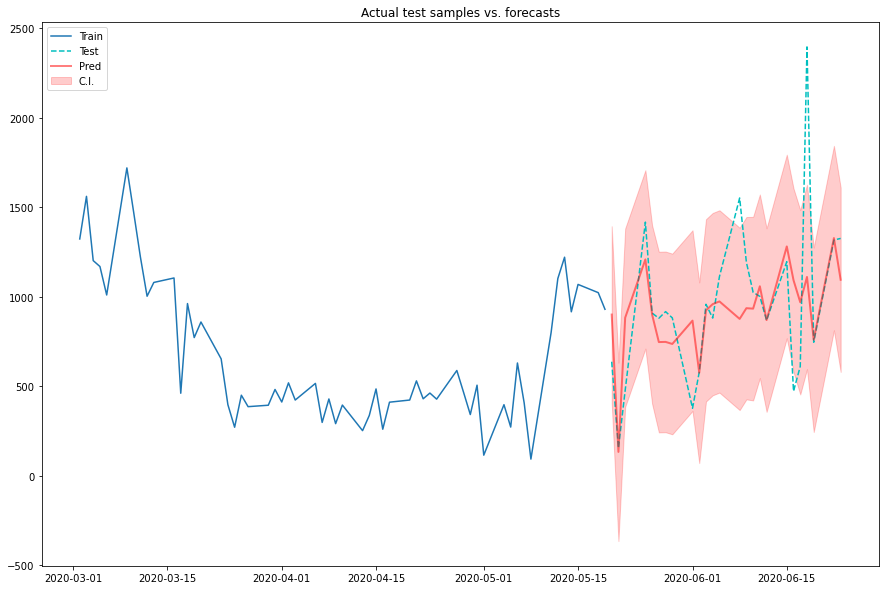

In [28]:
plt.rcParams['figure.figsize'] = [15, 10]
g1 = plt.plot(graphz.index, graphz.TOTAL, label='Train')
g2 = plt.plot(graphz.index, graphz.TEST,'c--', label='Test')
g3 = plt.plot(graphz.index, graphz.preds,'r', label='Pred',linewidth=2, alpha=.5)
# g3b = plt.plot(graphz.index, graphz.hwpreds,'g', label='Pred',linewidth=2)
g4 = plt.fill_between(graphz.index,graphz.lb,graphz.ub,color='r',alpha=.2, label='C.I.')
plt.legend(loc='upper left')
plt.title('Actual test samples vs. forecasts')
plt.show()